### HighIQ spectral processing example.

This notebook shows an example of how to process Doppler spectra from complex autocorrelation function (ACF) data. The example data in this notebook are from the Atmospheric Radiation Measurement program's Doppler Lidar in the Southern Great Plains site in Oklahoma. 

In [1]:
import highiq
import act
from datetime import datetime
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
file_path = '/nfs/gce/projects/digr/sgp_lidar/sgpdlacfC1.a1.20170804.000113.nc.v0'

HighIQ uses xarray as its basic data model. Therefore, if you have ACF data in netCDF format, HighIQ will be able to load it without any preprocessing steps. The input dataset must contain 2 four dimensional arrays where the dimensions represent (time, number of samples, number of lags, and real/complex component) such as in the example dataset below.

In [3]:
my_ds = highiq.io.load_arm_netcdf(file_path)
my_ds

<xarray.Dataset>
Dimensions:      (complex: 2, nlags: 20, nsamples: 4000, time: 2184)
Coordinates:
  * nlags        (nlags) int16 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * complex      (complex) int16 1 2
  * time         (time) datetime64[ns] 2017-08-04T00:01:13.070000 ... 2017-08-04T00:59:59.900000
Dimensions without coordinates: nsamples
Data variables:
    base_time    (time) datetime64[ns] 2017-08-04 2017-08-04 ... 2017-08-04
    time_offset  (time) datetime64[ns] dask.array<chunksize=(2184,), meta=np.ndarray>
    azimuth      (time) float32 dask.array<chunksize=(2184,), meta=np.ndarray>
    elevation    (time) float32 dask.array<chunksize=(2184,), meta=np.ndarray>
    acf_bkg      (time, nsamples, nlags, complex) float32 dask.array<chunksize=(2184, 4000, 20, 2), meta=np.ndarray>
    acf          (time, nsamples, nlags, complex) float32 dask.array<chunksize=(2184, 4000, 20, 2), meta=np.ndarray>
    lat          (time) float32 36.6053 36.6053 36.6053 ... 36.6053 36.6053

The first step with this dataset is to process the doppler spectra from the ACF data. HighIQ makes this easy given you have an xarray dataset that has similar specifications to the dataset above. 

In [4]:
%time my_ds = highiq.calc.get_psd(my_ds)
my_ds

/home/rjackson/.conda/envs/spectra_env/lib/python3.7/site-packages/xarray/core/computation.py:609: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


CPU times: user 56.3 s, sys: 5.06 s, total: 1min 1s
Wall time: 38.1 s


<xarray.Dataset>
Dimensions:                        (complex: 2, freq: 32, nlags: 20, nsamples: 4000, range: 400, time: 2184, vel_bin_interp: 256, vel_bins: 32)
Coordinates:
  * range                          (range) float64 0.0 30.0 ... 1.197e+04
  * time                           (time) datetime64[ns] 2017-08-04T00:01:13.070000 ... 2017-08-04T00:59:59.900000
  * vel_bin_interp                 (vel_bin_interp) float64 -19.35 ... 18.14
  * vel_bins                       (vel_bins) float64 -19.35 -18.14 ... 18.14
  * nlags                          (nlags) int16 0 1 2 3 4 5 ... 15 16 17 18 19
  * complex                        (complex) int16 1 2
Dimensions without coordinates: freq, nsamples
Data variables:
    base_time                      (time) datetime64[ns] 2017-08-04 ... 2017-08-04
    time_offset                    (time) datetime64[ns] dask.array<chunksize=(2184,), meta=np.ndarray>
    azimuth                        (time) float32 dask.array<chunksize=(2184,), meta=np.ndarray>


## Plotting power spectra

Power spectra then can be plotting using the standard .sel and .plot() commands that are built into xarray.
For example, if we want to pick out a certain range and time to plot the power spectra at, we can
simply use the below code.

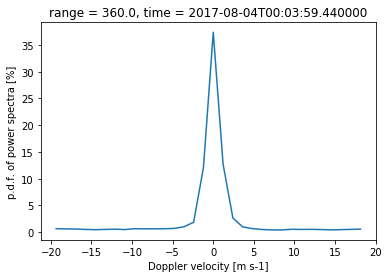

In [5]:
my_time = datetime.datetime(2017, 8, 4, 0, 4, 0)
my_ds["power_spectra_normed"].sel(time=my_time, range=350., method='nearest').plot()

Notice how the power spectra are not very smooth. This is because "power_spectra_normed" contains
the data points in the power spectra without any interpolation. We can use interpolation to create smoother
power spectra that provide greater numerical stability.

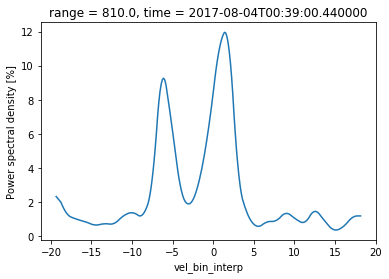

In [25]:
my_time = datetime.datetime(2017, 8, 4, 0, 39, 0)
my_ds["power_spectra_normed_interp"].sel(time=my_time, range=800., method='nearest').plot()
plt.save

In [7]:
my_ds["freq_bins"]

<xarray.DataArray 'freq_bins' (freq: 32)>
array([-25000000., -23437500., -21875000., -20312500., -18750000.,
       -17187500., -15625000., -14062500., -12500000., -10937500.,
        -9375000.,  -7812500.,  -6250000.,  -4687500.,  -3125000.,
        -1562500.,         0.,   1562500.,   3125000.,   4687500.,
         6250000.,   7812500.,   9375000.,  10937500.,  12500000.,
        14062500.,  15625000.,  17187500.,  18750000.,  20312500.,
        21875000.,  23437500.])
Dimensions without coordinates: freq
Attributes:
    long_name:  Doppler spectra bins in frequency units
    units:      Hz

In [8]:
my_ds = highiq.calc.get_moments(my_ds)
my_ds

<xarray.Dataset>
Dimensions:                        (complex: 2, freq: 32, nlags: 20, nsamples: 4000, range: 400, time: 2184, vel_bin_interp: 256, vel_bins: 32)
Coordinates:
  * range                          (range) float64 0.0 30.0 ... 1.197e+04
  * time                           (time) datetime64[ns] 2017-08-04T00:01:13.070000 ... 2017-08-04T00:59:59.900000
  * vel_bin_interp                 (vel_bin_interp) float64 -19.35 ... 18.14
  * vel_bins                       (vel_bins) float64 -19.35 -18.14 ... 18.14
  * nlags                          (nlags) int16 0 1 2 3 4 5 ... 15 16 17 18 19
  * complex                        (complex) int16 1 2
Dimensions without coordinates: freq, nsamples
Data variables:
    base_time                      (time) datetime64[ns] 2017-08-04 ... 2017-08-04
    time_offset                    (time) datetime64[ns] dask.array<chunksize=(2184,), meta=np.ndarray>
    azimuth                        (time) float32 dask.array<chunksize=(2184,), meta=np.ndarray>


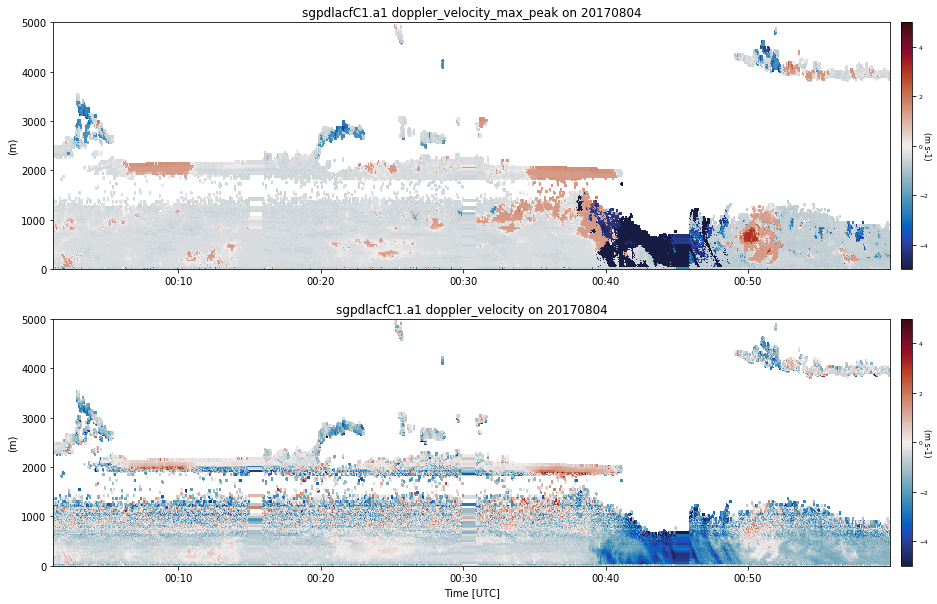

In [21]:
my_ds['doppler_velocity_max_peak'] = my_ds['doppler_velocity_max_peak'].where(my_ds.intensity > 1.2)
my_ds['doppler_velocity'] = my_ds['doppler_velocity'].where(my_ds.intensity > 1.2)
my_display = act.plotting.TimeSeriesDisplay(my_ds, figsize=(15,10), subplot_shape=(2,))
my_display.plot('doppler_velocity_max_peak', subplot_index=(0,), cmap='act_balance', vmin=-5, vmax=5)
my_display.plot('doppler_velocity', subplot_index=(1,), cmap='act_balance', vmin=-5, vmax=5)
my_display.set_yrng([0, 5000], subplot_index=(0,))
my_display.set_yrng([0, 5000], subplot_index=(1,))
my_display.fig.savefig('spectra_difference.png', dpi=300)

In [8]:
my_ds['range']

<xarray.DataArray 'range' (range: 400)>
array([    0.,    30.,    60., ..., 11910., 11940., 11970.])
Coordinates:
  * range    (range) float64 0.0 30.0 60.0 ... 1.191e+04 1.194e+04 1.197e+04

In [8]:
my_ds['range'].attrs['long_name'] = "Range"
my_ds['range']

<xarray.DataArray 'range' (range: 400)>
array([    0.,    30.,    60., ..., 11910., 11940., 11970.])
Coordinates:
  * range    (range) float64 0.0 30.0 60.0 ... 1.191e+04 1.194e+04 1.197e+04
Attributes:
    long_name:  Range

In [ ]:
my_display.